Not done yet & to try:

- add constant terms to QAOA
- have a 2nd check at T operation

In [13]:
#BASE
import networkx as nx
from collections import Counter, defaultdict, namedtuple
from itertools import product
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm
import numpy as np

#ML
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as CK
from sklearn.preprocessing import StandardScaler
from sklearn.utils.optimize import _check_optimize_result
from scipy.optimize import minimize

#QUANTUM
from qiskit import Aer, QuantumCircuit, execute

#VIZ
from matplotlib import pyplot as plt

#Set global parameters
s_eigenvalues = [0,1]
penalty = 2
shots = 1000

#Set graph instance & its complement
E = [(0,1), (1,2), (0,2), (2,3), (2,4)]; N = 5
G = nx.Graph()
G.add_nodes_from(range(N))
G.add_edges_from(E)
G_comp = nx.complement(G)

In [14]:
#Functions

def draw_graph(G):
    
    G_comp = nx.complement(G)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (8,4))
    axes[0].set_title("GRAPH")
    axes[1].set_title("COMPLEMETARY GRAPH")
    pos = nx.circular_layout(G)
    nx.draw_networkx(G,ax=axes[0],pos=pos)
    pos = nx.circular_layout(G_comp)
    nx.draw_networkx(G_comp,ax=axes[1],node_color="r",pos=pos)

def s2z(configuration):
    
    return [1-2*s for s in configuration]

def z2s(s):
    
    return [(1-z)/2 for z in configuration]

def str2list(s):
    
    l = []
    skip=False
    for x in s:
        if skip==True:
            skip=False
            continue
        if x == "-":
            l.append(-1)
            skip=True
        if x != "-":
            l.append(int(x))
    return l

def evaluate_cost(configuration, penalty=penalty, basis=None):
    
    '''
    configuration: eigenvalues
    '''
    
    cost=0
    if basis=="S":
        cost = -sum(configuration)
        for edge in G_comp.edges:
            cost += penalty*(configuration[edge[0]]*configuration[edge[1]])            
    elif basis=="Z":          
        cost = -(len(configuration) - sum(configuration))/2 
        for edge in G_comp.edges:
            cost += penalty/4*(1-configuration[edge[0]])*(1-configuration[edge[1]])
    else:
        raise ValueError('Basis should be specified: it must one of ["S","Z"]')
    return cost

def classical_solution(basis=None, show_top=None):  
    
    '''
    Runs through all 2^n possible configurations and estimates how many max cliques there are and plots one
    '''
    
    results = {}
    
    if basis=="S":
        eigenvalues = s_eigenvalues #[0, 1] i.e. eigenvalues for |0> ad |1> respectively
    elif basis=="Z": 
        eigenvalues = s2z(s_eigenvalues) #[1,-1] i.e. eigenvalues for |0> ad |1> respectively
    else:
        raise ValueError('Basis should be specified: it must one of ["S","Z"]')
        
    eigen_configurations = list(product(eigenvalues, repeat=len(G)))
    for eigen_configuration in tqdm(eigen_configurations):
        results[eigen_configuration] = evaluate_cost(eigen_configuration, basis=basis)
    
    print('All possible solutions: \n')
    sol = pd.DataFrame(np.unique(list(results.values()), return_counts = True)).T
    sol.columns=["energy","occurrencies"]
    sol["frequency"]=round(sol["occurrencies"]/sol["occurrencies"].sum()*100,0)
    if show_top is not None:
        print(sol.head(show_top))
    else:
        print(sol)
    d = dict((k, v) for k, v in results.items() if v == np.min(list(results.values())))
    print(f'\nThere are {len(d)} MAXCLIQUE(S) with eigenvalues configuration(s) in basis \"{basis}\": {d}')
    
    fig = plt.subplot(1, 2, 1)
    val, counts = np.unique(list(results.values()), return_counts = True)
    plt.bar(val, counts)
    plt.xlabel('Energy')
    plt.ylabel('Counts')
    plt.title('Statistics of solutions')

    fig = plt.subplot(1, 2, 2)
    plt.title('MaxClique')
    colors = list(d.keys())[0]
    pos = nx.circular_layout(G)
    nx.draw_networkx(G, node_color=colors, node_size=200, alpha=1, pos=pos)
    
def quantum_algorithm(gamma, beta, penalty):
    
    qc = QuantumCircuit(N,N)
    qc.h(range(N))

    for edge in G_comp.edges: 
        qc.rzz(gamma*penalty/2, edge[0], edge[1])
        qc.rz(-gamma*penalty/2, edge[0]) 
        qc.rz(-gamma*penalty/2, edge[1]) 
        
    for i in G.nodes:
        qc.rz(gamma, i) 
        
    qc.rx(2*beta, range(N)) 
    
    meas = QuantumCircuit(N,N)
    meas.barrier(range(N))
    meas.measure(range(N), range(N))

    return qc + meas
    
def QAOA(gamma, beta, penalty=penalty, shots=shots, basis="S"):
    
    '''
    Applies QAOA
    '''
    backend = Aer.get_backend("qasm_simulator")
    qc = quantum_algorithm(gamma, beta, penalty)
    simulate = execute(qc, backend=backend, shots=shots)
    results = simulate.result()
    extimated_f1 = 0
    counts = results.get_counts()
    pretty_counts = {k[::-1]:v for k,v in counts.items()} 
    if basis=="S":
        pass
    elif basis=="Z":
        pretty_counts = {"".join([str(x) for x in s2z([int(x) for x in k])]):v for k,v in pretty_counts.items()}
    else:
        raise ValueError('Basis should be specified: it must one of ["S","Z"]')

    for configuration in pretty_counts:
        prob_of_configuration = pretty_counts[configuration]/shots
        extimated_f1 += prob_of_configuration*evaluate_cost(str2list(configuration), basis=basis)
    
    return extimated_f1, pretty_counts

def grid_search(num_params, penalty=penalty, shots=shots, param_range = np.pi, show_plot=True):

    QAOA_results = []
    Point = namedtuple("Point", "gamma beta f1")
    lin = np.linspace(0, param_range, num_params)
    params = np.array(list((product(lin, repeat = 2))))
    
    X = np.unique(params[:,0])
    Y = np.unique(params[:,1])
    X, Y = np.meshgrid(X, Y)
    Q = np.zeros((len(X),len(X)))
    
    for i,j in tqdm(list(product(range(len(X)),repeat=2))):
        Q[i,j], _ = QAOA(X[i,j],Y[i,j], penalty=penalty, shots=shots, basis="S")
    
    if show_plot:

        plt.imshow(Q, extent = [0, param_range, param_range, 0])
        plt.title('Grid Search: [{} x {}]'.format(len(X), len(X)))
        plt.xticks(fontsize = 15)
        plt.yticks(fontsize = 15)

        cb = plt.colorbar()
        plt.xlabel(r'$\gamma$', fontsize=20)
        plt.ylabel(r'$\beta$', fontsize =20)
        cb.ax.tick_params(labelsize=15)
        
        points = [Point(*x) for x in np.dstack((X,Y,Q)).reshape(-1,3)]
        
        return points
    
def plot_distribution(freq_dict):

    sorted_freq_dict = dict(sorted(freq_dict.items(), key=lambda item: item[1], reverse=True))
    color_dict = {key: 'g' for key in sorted_freq_dict}
    plt.figure(figsize=(12,6))
    plt.xlabel("configuration")
    plt.ylabel("counts")
    plt.xticks(rotation='vertical')
    plt.bar(sorted_freq_dict.keys(), sorted_freq_dict.values(), width=0.5, color = color_dict.values())
    
#def plot_f1_landscape(params, f1):
#    
#    fig = plt.figure()

#    # Make data.
#    X = np.unique(params[:,0])
#    Y = np.unique(params[:,1])
#    X, Y = np.meshgrid(X, Y)
#    Z = np.reshape(f1, (len(X), len(Y)))

    # Plot the surface.
#    plt.imshow(Z, extent = [0, np.pi, np.pi, 0])
#    plt.title('Grid Search: [{} x {}]'.format(len(X), len(X)))
#    plt.xticks(fontsize = 15)
#    plt.yticks(fontsize = 15)
    
#    cb = plt.colorbar()
#    plt.xlabel(r'$\gamma$', fontsize=20)
#    plt.ylabel(r'$\beta$', fontsize =20)
#    cb.ax.tick_params(labelsize=15)
    
def spectrum_vs_penalty(penalty_min=-2, penalty_max=3, penalty_step=0.5, show_plot=True, basis="S"):
    
    configuration_energies = defaultdict(list)
    penalties=np.arange(penalty_min, penalty_max, penalty_step)
    
    if basis == "S":
        eigenvalues = s_eigenvalues
    elif basis=="Z":
        eigenvalues = s2z(s_eigenvalues)

    for eigen_configuration in product(eigenvalues, repeat = len(G)):
        for penalty in penalties:
            configuration_energies[str(eigen_configuration)].append(evaluate_cost(str2list(eigen_configuration), penalty, basis=basis))

    degeneracies_df = pd.DataFrame(sorted(Counter([v[-1] for k,v in configuration_energies.items()]).items(), key=lambda item: item[0], reverse=False))
    degeneracies_df.columns=["energy","eigenstates"]

    if show_plot:

        for k, v in configuration_energies.items():
            plt.plot(penalties, v, label = k, marker="o")
            plt.xlabel("penalty")
            plt.ylabel("cost")
            plt.legend(title="eigen_configuration",bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

    return degeneracies_df, configuration_energies

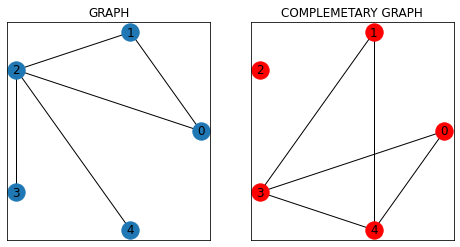

In [15]:
draw_graph(G)

100%|███████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 32048.17it/s]


All possible solutions: 

   energy  occurrencies  frequency
0    -3.0           1.0        3.0
1    -2.0           5.0       16.0
2    -1.0          10.0       31.0
3     0.0           8.0       25.0
4     1.0           2.0        6.0
5     2.0           2.0        6.0
6     3.0           2.0        6.0
7     5.0           1.0        3.0
8     6.0           1.0        3.0

There are 1 MAXCLIQUE(S) with eigenvalues configuration(s) in basis "Z": {(-1, -1, -1, 1, 1): -3.0}


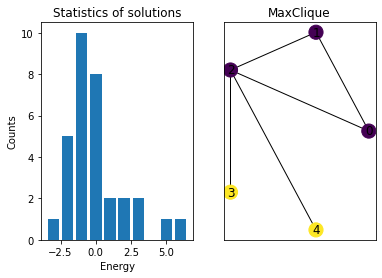

In [16]:
classical_solution(basis="Z")

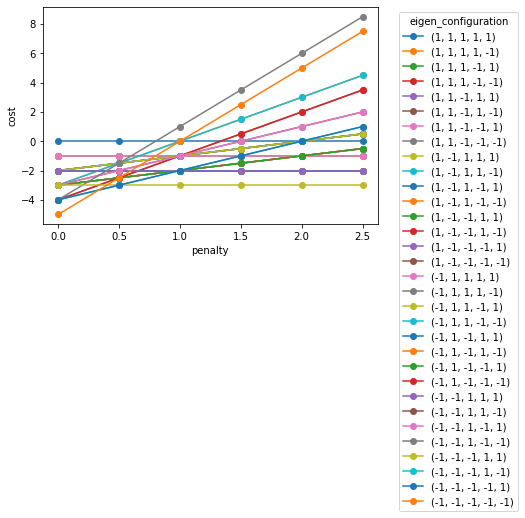

The degeneracies at penalty_max are:


,energy,eigenstates
0,-3.0,1
1,-2.0,5
2,-1.0,5
3,-0.5,5
4,0.0,1
5,0.5,5
6,1.0,2
7,2.0,2
8,3.5,2
9,4.5,2


In [17]:
degeneracies_df, configuration_energies = spectrum_vs_penalty(penalty_min=0, penalty_max=3, penalty_step=0.5, basis="Z")
print("The degeneracies at penalty_max are:")
degeneracies_df

### Gaussian Process to approximate the f1 landscape of a graph

Generates $N_{train}$ points selected randomly on a grid $[gamma-extremes] \times [beta-extremes]$, trains a sklearn Gaussin Process Regressor with a kernel defined by kernel and tests it on $N_{test}^2$ samples uniformly picked on a grid $[0, max(gamma, betas)] \times [0, max(gamma, betas)] $. Result is compared to grid search

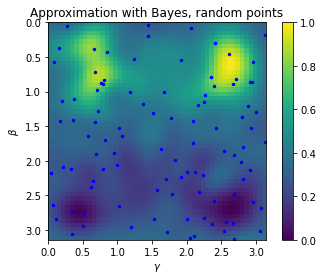

In [18]:
N_train = 100
N_test = 50
gamma_extremes = [0, np.pi]
beta_extremes = [0, np.pi]
X_train = []; y_train = []

for i in range(N_train):
    X = [np.random.uniform(*gamma_extremes), np.random.uniform(*beta_extremes)]
    X_train.append(X)
    Y, _ = QAOA(*X) 
    y_train.append(Y)

kernel = CK(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=0, normalize_y = True)
gp.fit(X_train, y_train)

X_lin = np.linspace(0, np.max([gamma_extremes, beta_extremes]), N_test) 
X_test_grid = list(product(X_lin, X_lin))

predicted_means = gp.predict(X_test_grid) 
res = np.reshape(predicted_means, (N_test, N_test)).T #extremes is (left,right,bommot,top)
X_train = np.array(X_train)
plt.title('Approximation with Bayes, random points')
plt.imshow(res, extent = gamma_extremes + beta_extremes[::-1]) #extremes is (left,right,bommot,top) [0,np.pi,np.pi,0]
plt.scatter(X_train[:,0], X_train[:,1], s=6, c='b')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\beta$')
plt.colorbar()

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:04<00:00, 84.40it/s]


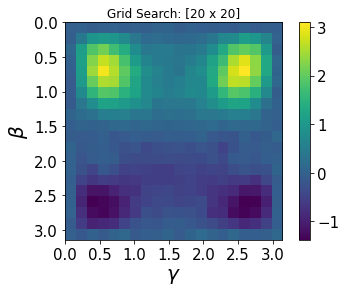

In [19]:
#To confront with
points = grid_search(20)

In [20]:
optimal_point = points[np.argmin([p.f1 for p in points])]
optimal_f1 = optimal_point.f1 #chiaramente è difficile aspettarsi che sia il minimo esatto, perché è un valore di aspettazione
optimal_params = [optimal_point.gamma, optimal_point.beta]

### Let's see how the QAOA performs on the "optimal" parameters found the by the grid search in the previous cell. Two criteria must be taken into account:

- time
- quality of solution (we could use as a FEM, the approximation ration)

,eigen_configuration,energy,occurrencies,frequency
0,11-1-11,-2.0,1130,11.0
1,-1-1-111,-3.0,1110,11.0
2,11-11-1,-2.0,1089,11.0
3,11-111,-1.0,983,10.0
4,-11-111,-2.0,858,9.0
5,1-1-111,-2.0,811,8.0
6,-1-1111,-2.0,496,5.0
7,111-11,-1.0,477,5.0
8,1111-1,-1.0,468,5.0
9,11111,0.0,433,4.0


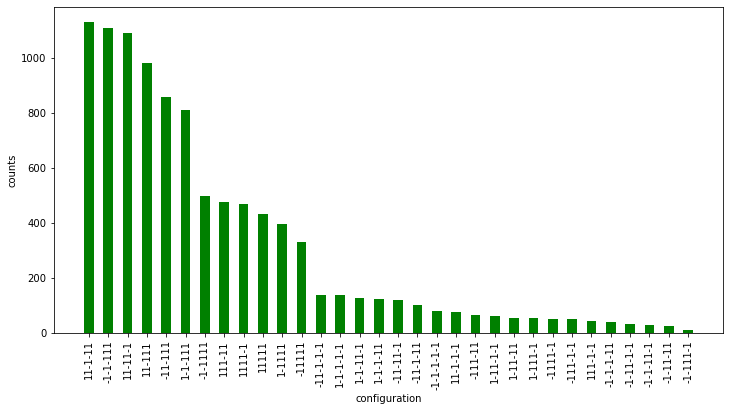

In [21]:
#lo stato cercato è sempre della top 3 ma non è detto sia sempre il primo... sentire D e S

basis="Z"

extimated_f1, pretty_counts = QAOA(*optimal_params, shots=10000, basis=basis) #prendo un numero molto grande di shots per stabilizzare la distribuzione (legge grandi numeri)
plot_distribution(pretty_counts)
sol = pd.DataFrame(dict(sorted(pretty_counts.items(), key=lambda item: item[1], reverse=True)),index=[0]).T.reset_index()
sol.columns=["eigen_configuration","occurrencies"]
sol["frequency"]=round(sol["occurrencies"]/sol["occurrencies"].sum()*100,0)#.head(3)
sol["energy"]=sol["eigen_configuration"].apply(lambda x: evaluate_cost(str2list(x),basis=basis))
sol=sol[["eigen_configuration","energy","occurrencies","frequency"]]
sol.head(10)

### Bayesian Optimization to find the minimum of the f1 of a graph


In [22]:
#Allows to change max_iter (see cell below) as well as gtol. It can be straightforwardly extended to other parameters
class MyGaussianProcessRegressor(GaussianProcessRegressor):
    def __init__(self, *args, max_iter=2e05, gtol=1e-06, **kwargs):
        super().__init__(*args, **kwargs)
        self._max_iter = max_iter
        self._gtol = gtol

    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        if self.optimizer == "fmin_l_bfgs_b":
            opt_res = minimize(obj_func, initial_theta, method="L-BFGS-B", jac=True, bounds=bounds, options={'maxiter':self._max_iter, 'gtol': self._gtol})
            _check_optimize_result("lbfgs", opt_res)
            theta_opt, func_min = opt_res.x, opt_res.fun
        elif callable(self.optimizer):
            theta_opt, func_min = self.optimizer(obj_func, initial_theta, bounds=bounds)
        else:
            raise ValueError("Unknown optimizer %s." % self.optimizer)
        return theta_opt, func_min
    
def rescaler(x, min_old=0, max_old=np.pi, min_new=0, max_new=1):
    
    x_sc = min_new + (max_new - min_new)/(max_old - min_old)*(x - min_old)
    
    return x_sc

In [44]:
final_states = []
for n_shots in range(100, 1001, 100):
    print(n_shots)
    acq_function = 'EI'
    N_train = 1
    N_test = 100
    iterations = 100
    gamma_extremes = [0.1, np.pi]; beta_extremes = [0.1, np.pi]
    X_train = []; y_train = []

    #seed
    my_seed = 42
    np.random.seed(my_seed)

    for i in range(N_train):
        X = [np.random.uniform(*gamma_extremes), np.random.uniform(*beta_extremes)]
        print(X)
        #X = [1.5000,1.5000]
        X_train.append(X)
        Y, _ = QAOA(*X, shots = n_shots)
        y_train.append(Y)

    X= np.linspace(0.1, np.max([gamma_extremes, beta_extremes]), N_test)
    X_test = list(product(X, X))

    X_train = rescaler(np.array(X_train)).tolist()
    X_test = rescaler(np.array(X_test)).tolist()

    #create gaussian process and fit training data
    kernel = CK(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
    gp = MyGaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1, alpha = 1e-2, normalize_y = True, max_iter = 50000)
    gp.fit(X_train, y_train)

    #At each iteration we calculate the best point where to sample from
    sample_points = []   #We save every point that was chosen to sample from

    for i in range(iterations):

            # Test GP
            new_mean, new_sigma = gp.predict(X_test, return_std=True)

            #New_mean and new_sigma both are (N_test**2, ) arrays not reshaped yet
            mean_max = np.max(new_mean)
            mean_min = np.min(new_mean)

            #Now calculate acquisitition fn as the cumulative for every point centered around the maximum
            cdf = norm.cdf(x = new_mean, loc =  mean_max, scale = new_sigma)
            pdf = norm.pdf(x = new_mean, loc =  mean_min, scale = new_sigma)

            #The qdf is instead the probability of being lower then the lowest value of the mean (where we wanto to pick the next_value)
            qdf = 1-norm.cdf(x = new_mean, loc =  mean_min, scale = new_sigma)

            if acq_function == 'PI':
                #Next values is calculated as so just because argmax returns a number betwenn 1 and n_test instead of inside the interval
                value = np.argmax(qdf)
                next_point = X_test[value]

            if acq_function == 'EI':
                alpha_function = (new_mean - mean_min - 0.001)*qdf + new_sigma*pdf
                #argmax is a number between 0 and N_test**-1 telling us where is the next point to sample
                argmax = np.argmax(np.round(alpha_function, 3))
                next_point_normalized = X_test[argmax]

            next_point = rescaler(np.array(next_point_normalized), min_old=0, max_old=1, min_new=0, max_new=np.pi)
            X_train.append(next_point_normalized)
            y_next_point,_ = QAOA(*next_point, shots = n_shots)
            y_train.append(y_next_point)
            print(i, next_point, y_next_point)

            gp.fit(X_train, y_train)
            sample_points.append(next_point)
    optimal_points = sample_points[-1]
    optimal_f1, counts = QAOA(*optimal_points,shots=n_shots)
    final_states.append(optimal_f1)
    print('reached limit')

100
[1.2391984739607858, 2.9916856500391167]
0 [0.1 0.1] 0.14999999999999994
1 [1.23675685 2.98797686] -0.4100000000000002
2 [1.23675685 2.92653055] -0.5100000000000001
3 [1.17531053 2.98797686] -0.4900000000000001


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found f

4 [1.20603369 2.98797686] -0.15000000000000002
5 [1.26748001 2.9572537 ] -0.07000000000000012
6 [1.14458738 2.9572537 ] -0.030000000000000165
7 [1.14458738 3.01870002] -0.05000000000000006


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

8 [1.20603369 2.9572537 ] -0.48000000000000004
9 [1.23675685 2.9572537 ] 0.010000000000000184
10 [1.23675685 2.86508423] -0.05000000000000012
11 [1.29820317 2.89580739] -0.36


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

12 [1.17531053 2.89580739] -0.23
13 [1.32892632 2.9572537 ] -0.31000000000000005
14 [0.1        0.22289263] 0.67
15 [1.20603369 2.89580739] -0.12999999999999998
16 [1.11386422 2.86508423] -0.32999999999999996
17 [1.0524179  2.83436107] -0.8200000000000001


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

18 [1.02169474 2.80363791] -0.67
19 [1.02169474 2.86508423] -0.2700000000000002
20 [1.08314106 2.80363791] -0.74
21 [1.0524179  2.77291476] -0.2899999999999999


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

22 [1.14458738 2.80363791] -0.46
23 [0.96024843 2.80363791] -0.78
24 [0.92952527 2.77291476] -0.75


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

25 [0.99097159 2.77291476] -0.24000000000000007
26 [0.92952527 2.83436107] -0.5800000000000001
27 [1.26748001 2.89580739] -0.14000000000000004


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

28 [0.89880211 2.80363791] -1.0699999999999998
29 [0.89880211 2.80363791] -0.83
30 [0.92952527 2.80363791] -0.99


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

31 [0.92952527 2.80363791] -0.5600000000000002
32 [0.86807895 2.80363791] -0.7000000000000002
33 [0.89880211 2.77291476] -1.02


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

34 [0.89880211 2.77291476] -0.54
35 [0.89880211 2.80363791] -0.4
36 [1.08314106 2.83436107] -0.21000000000000013


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

37 [1.11386422 2.77291476] -0.11000000000000013
38 [1.0524179  2.80363791] -0.32
39 [0.99097159 2.83436107] -0.6900000000000002


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

40 [1.02169474 2.83436107] -1.0
41 [1.02169474 2.83436107] -0.2700000000000002
42 [1.35964948 2.89580739] -0.5


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

43 [1.0524179  2.86508423] 0.020000000000000025
44 [0.96024843 2.89580739] -0.12000000000000002


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


45 [1.14458738 2.86508423] -0.2500000000000001
46 [1.0524179  2.71146844] -0.44999999999999996


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

47 [0.89880211 2.71146844] -0.8
48 [0.86807895 2.68074528] -0.74
49 [0.92952527 2.68074528] -0.66


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

50 [0.83735579 2.71146844] -1.06
51 [0.83735579 2.7421916 ] -1.31


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


52 [0.83735579 2.7421916 ] -0.8700000000000001
53 [0.80663264 2.7421916 ] -1.1


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


54 [0.80663264 2.71146844] -0.9099999999999999
55 [0.80663264 2.7421916 ] -0.9300000000000002


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


56 [0.83735579 2.7421916 ] -0.8800000000000001
57 [0.83735579 2.71146844] -1.05
58

C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


 [0.83735579 2.71146844] -1.01
59 [0.83735579 2.71146844] -1.0100000000000002


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

60 [0.80663264 2.77291476] -1.1400000000000001
61 [0.80663264 2.77291476] -0.3000000000000001
62 [0.83735579 2.71146844] -1.12
63 [0.83735579 2.71146844] -1.12


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


64 [0.83735579 2.71146844] -0.74
65 [0.83735579 2.7421916 ] -1.0


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


66 [0.83735579 2.7421916 ] -0.78
67 [0.77590948 2.7421916 ] -0.81


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


68 [0.80663264 2.7421916 ] -0.97
69 [0.83735579 2.71146844] -0.78


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


70 [0.80663264 2.7421916 ] -0.5700000000000001
71 [0.86807895 2.7421916 ] -1.1099999999999999


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


72 [0.86807895 2.7421916 ] -0.47000000000000014
73 [0.74518632 2.71146844] -0.74


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


74 [0.83735579 2.71146844] -0.96
75 [0.83735579 2.71146844] -0.48


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


76 [0.80663264 2.65002212] -1.13
77 [0.77590948 2.65002212] -1.06


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


78 [0.80663264 2.61929897] -0.8900000000000001
79 [0.80663264 2.65002212] -0.87


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


80 [0.77590948 2.68074528] -1.15
81 [0.77590948 2.68074528] -1.36


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


82 [0.77590948 2.68074528] -1.07
83 [0.77590948 2.68074528] -1.12


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


84 [0.77590948 2.68074528] -1.07
85 [0.77590948 2.68074528] -1.0


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


86 [0.77590948 2.68074528] -0.6200000000000001
87 [0.74518632 2.65002212] -1.01


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


88 [0.74518632 2.61929897] -1.08
89 [0.71446316 2.61929897] -1.2400000000000002


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


90 [0.71446316 2.58857581] -1.14


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


91 [0.71446316 2.61929897] -1.01


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


92 [0.68374    2.58857581] -0.9900000000000001


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


93 [0.71446316 2.58857581] -0.8500000000000001
94 [0.68374    2.61929897] -1.1700000000000002


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


95 [0.68374    2.65002212] -1.34
96 [0.68374    2.65002212] -1.1600000000000001


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


97 [0.65301685 2.65002212] -1.2200000000000002
98 [0.68374    2.65002212] -1.34


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


99 [0.68374    2.65002212] -0.8800000000000001
reached limit
200
[1.2391984739607858, 2.9916856500391167]
0 [0.1 0.1] 0.25499999999999995


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found f

1 [1.20603369 2.98797686] 0.16999999999999998
2 [1.26748001 2.98797686] -0.05500000000000009
3 [1.26748001 2.98797686] -0.33000000000000007
4 [1.29820317 3.01870002] -0.25000000000000006
5 [1.32892632 2.9572537 ] -0.15000000000000008
6 [1.29820317 2.98797686] -0.3700000000000001
7 [1.29820317 2.98797686] -0.004999999999999984
8 [1.26748001 3.04942318] -0.14500000000000005
9 [1.32892632 3.04942318] 0.19000000000000006
10 [1.26748001 3.01870002] 0.004999999999999904
11 [1.26748001 3.08014634] 0.25999999999999995


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

12 [1.26748001 2.9572537 ] -0.41000000000000003
13 [1.26748001 2.9572537 ] -0.24500000000000005
14 [1.26748001 2.9572537 ] -0.2600000000000001


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

15 [1.26748001 2.9572537 ] -0.44999999999999996
16 [1.26748001 2.9572537 ] -0.08000000000000007
17 [1.26748001 2.9572537 ] -0.3800000000000001


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

18 [1.26748001 2.9572537 ] 0.029999999999999864
19 [1.35964948 2.92653055] -0.26500000000000007
20 [1.32892632 2.89580739] -0.27499999999999997


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

21 [1.35964948 2.86508423] -0.32500000000000007
22 [1.39037264 2.89580739] -0.11000000000000007
23 [1.32892632 2.86508423] -0.22499999999999995
24 [1.35964948 2.83436107] -0.21000000000000002
25 [1.35964948 2.86508423] -0.15999999999999998
26 [1.32892632 2.92653055] -0.075


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

27 [1.39037264 2.9572537 ] -0.28000000000000014
28 [1.35964948 2.98797686] -0.18500000000000003
29 [1.35964948 2.89580739] -0.38
30 [1.35964948 2.89580739] -0.46499999999999997
31 [1.35964948 2.89580739] -0.07999999999999999


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

32 [1.35964948 2.89580739] -0.25000000000000006
33 [1.35964948 2.9572537 ] -0.1650000000000001
34 [1.4210958  2.98797686] -0.2700000000000002


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

35 [1.45181896 2.9572537 ] -0.12000000000000006
36 [1.35964948 2.89580739] -0.43500000000000005
37 [1.35964948 2.89580739] -0.24500000000000005


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

38 [1.35964948 2.89580739] -0.55
39 [1.35964948 2.89580739] -0.19000000000000006
40

C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

 [1.35964948 2.89580739] -0.020000000000000046
41 [1.4210958  3.01870002] -0.13499999999999998
42 [1.4210958 2.9572537] -0.42500000000000016


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


43 [1.4210958 2.9572537] -0.10000000000000009
44 [0.1        0.25361579] 0.61


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


45 [1.39037264 2.77291476] -0.28500000000000003
46 [1.35964948 2.7421916 ] -0.14999999999999997
47 [1.4210958  2.80363791] -0.63


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

48 [1.4210958  2.80363791] -0.0750000000000001
49 [1.4210958  2.77291476] -0.39
50 [1.4210958  2.77291476] -0.73


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


51 [1.4210958  2.77291476] -0.30000000000000004
52 [1.4210958  2.77291476] -0.17999999999999997
53 [1.45181896 2.77291476] -0.5750000000000001


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

54 [1.45181896 2.77291476] -0.5800000000000001
55 [1.45181896 2.77291476] -0.21000000000000008
56 [1.45181896 2.77291476] -0.35
57 [1.45181896 2.77291476] -0.355


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


58 [1.45181896 2.77291476] -0.17000000000000004
59 [1.4210958  2.77291476] -0.47


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


60 [1.4210958  2.77291476] -0.5
61 [1.4210958  2.77291476] -0.2350000000000001


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


62 [1.4210958  2.77291476] -0.6850000000000002
63 [1.4210958  2.77291476] 0.03499999999999981


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

64 [1.45181896 2.7421916 ] -0.2850000000000001
65 [1.45181896 2.80363791] 0.004999999999999977


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


66 [1.39037264 2.80363791] -0.15500000000000008
67 [1.48254212 2.7421916 ] -0.135


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


68 [1.4210958  2.77291476] -0.32999999999999996
69 [1.4210958  2.77291476] -0.37499999999999994


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


70 [1.4210958  2.77291476] -0.41500000000000004
71 [1.4210958  2.77291476] -0.06500000000000009


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


72 [1.45181896 2.77291476] -0.22999999999999998
73 [0.1        0.40723158] 0.42999999999999994


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


74 [0.1        0.53012421] 0.5899999999999999
75 [0.1        0.65301685] 0.6549999999999997


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


76 [0.1        0.77590948] 0.5099999999999997
77 [0.1        0.89880211] 0.4849999999999999
78 [0.1        1.02169474] 0.08500000000000003
79 [0.1        1.14458738] 0.35499999999999987
80 [0.1        1.26748001] 0.2400000000000001
81 [0.1        1.39037264] 0.065
82 [0.1        1.51326527] -0.27
83 [0.13072316 1.54398843] -0.2899999999999999
84 [0.1        1.57471159] -0.11000000000000004
85 [0.16144632 1.51326527] 0.17500000000000002
86 [0.16144632 1.57471159] -0.05999999999999995
87 [1.4210958  2.77291476] -0.41500000000000015
88 [1.4210958  2.77291476] -0.25999999999999995
89 [1.4210958  2.77291476] -0.15999999999999992


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


90 [1.4210958  2.83436107] -0.05500000000000008
91 [1.45181896 2.77291476] -0.030000000000000054
92 [1.4210958  2.80363791] -0.22999999999999995
93 [0.1        1.69760422] 0.4099999999999999
94 [0.1        1.82049685] -0.07500000000000004
95 [1.4210958  2.77291476] -0.48999999999999994
96 [1.4210958  2.77291476] -0.26
97 [1.4210958  2.77291476] -0.6000000000000001
98 [1.4210958  2.77291476] -0.46
99 [1.4210958  2.77291476] -0.58
reached limit
300
[1.2391984739607858, 2.9916856500391167]
0 [0.1 0.1] 0.5233333333333332
1 [1.23675685 2.98797686] 0.043333333333333404
2 [1.23675685 3.04942318] -0.19333333333333327


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found f

3 [1.26748001 3.01870002] -0.34666666666666673
4 [1.23675685 3.01870002] -0.29
5 [1.26748001 3.01870002] 0.01666666666666663


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


6 [1.23675685 3.01870002] -0.1166666666666667
7 [1.14458738 3.08014634] -0.18333333333333335
8 [1.17531053 3.04942318] -0.13999999999999996
9 [1.0524179  3.04942318] 0.15333333333333332


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


10 [1.20603369 3.08014634] -0.04666666666666669
11 [1.11386422 3.14159265] -0.12666666666666662
12 [1.23675685 3.01870002] -0.30666666666666664
13 [1.23675685 3.01870002] -0.14333333333333334


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


14 [0.1        0.31506211] 0.9266666666666662
15 [0.1        0.56084737] 0.6633333333333333
16 [0.1        0.83735579] 0.52
17 [0.1        1.08314106] 0.10333333333333333
18 [0.1        1.29820317] 0.15
19 [1.23675685 3.01870002] -0.0733333333333333
20 [0.1        1.54398843] -0.006666666666666623
21 [1.26748001 3.04942318] 0.20666666666666675
22 [1.29820317 2.98797686] -0.27999999999999997
23 [1.26748001 2.98797686] -0.26000000000000006
24 [1.29820317 2.98797686] -0.1366666666666666
25 [1.26748001 2.98797686] -0.0666666666666667
26 [1.11386422 3.08014634] -0.21666666666666662
27 [1.35964948 2.98797686] -0.14999999999999988
28 [1.11386422 3.1108695 ] -0.11999999999999994
29 [1.11386422 3.01870002] -0.2699999999999999
30 [1.11386422 3.04942318] -0.16333333333333336
31 [1.11386422 2.9572537 ] -0.19333333333333316
32 [1.11386422 2.98797686] 0.15666666666666665
33 [1.08314106 2.92653055] -0.06000000000000005
34 [1.14458738 2.92653055] -0.04999999999999995


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

35 [1.14458738 3.01870002] -0.47999999999999987
36 [1.14458738 3.01870002] -0.3333333333333333
37 [1.14458738 3.01870002] -0.2033333333333334


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

38 [1.14458738 3.01870002] -0.12000000000000012
39 [1.11386422 2.92653055] -0.2166666666666665
40 [1.14458738 3.01870002] -0.15666666666666654


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

41 [1.32892632 2.9572537 ] -0.2466666666666667
42 [1.35964948 2.92653055] -0.22333333333333324
43

C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

 [1.32892632 2.89580739] -0.4033333333333333
44 [1.32892632 2.89580739] -0.26


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


45 [1.29820317 2.89580739] -0.34333333333333343
46 [1.29820317 2.86508423] -0.24666666666666667


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


47 [1.32892632 2.92653055] -0.020000000000000084
48 [1.35964948 2.86508423] -0.21000000000000005
49

C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


 [1.32892632 2.86508423] -0.3433333333333333
50 [1.39037264 2.92653055] 0.00999999999999992
51 [1.26748001 2.89580739] -0.3233333333333333


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

52 [1.29820317 2.89580739] -0.13666666666666663
53 [1.35964948 2.89580739] -0.25999999999999995


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


54 [1.23675685 2.89580739] -0.31
55 [1.23675685 2.86508423] -0.1633333333333333


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

56 [1.32892632 2.86508423] -0.1666666666666666
57 [1.32892632 2.98797686] -0.22333333333333333
58 [1.35964948 2.9572537 ] -0.31666666666666665


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


59 [1.32892632 2.89580739] -0.41
60 [1.32892632 2.89580739] -0.26


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


61 [1.32892632 2.89580739] -0.46666666666666673
62 [1.32892632 2.89580739] -0.41999999999999993


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


63 [1.32892632 2.89580739] -0.3666666666666666
64 [1.32892632 2.89580739] -0.1833333333333334


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


65 [1.32892632 2.89580739] -0.3033333333333333
66 [1.32892632 2.89580739] -0.08999999999999973


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


67 [1.26748001 2.89580739] -0.18333333333333335
68 [1.32892632 2.89580739] -0.41000000000000003


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


69 [1.32892632 2.89580739] 0.036666666666666625
70 [1.20603369 2.89580739] -0.4233333333333333


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


71 [1.20603369 2.89580739] -0.28
72 [1.20603369 2.89580739] -0.3466666666666667


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


73 [1.20603369 2.89580739] -0.33000000000000007
74 [1.20603369 2.89580739] -0.3133333333333335


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


75 [1.20603369 2.89580739] -0.2800000000000001
76 [1.4210958  2.80363791] -0.1066666666666667


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
<ipython-input-22-781a3129b33c>:11: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


77 [1.20603369 2.89580739] -0.38666666666666677
78 [1.20603369 2.89580739] -0.34000000000000014


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


79 [1.20603369 2.89580739] -0.2833333333333334
80 [0.1        0.43795474] 0.7833333333333334


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


81 [0.1        1.66688106] -0.10666666666666665
82 [1.17531053 2.86508423] -0.13000000000000003


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


83 [0.1     0.68374] 0.7733333333333334
84 [0.1        0.96024843] 0.6133333333333334
85 [0.1       1.4210958] 0.27333333333333326
86 [0.1        1.75905054] -0.0066666666666666055
87 [1.20603369 2.89580739] -0.02333333333333331
88 [0.1        1.85122001] -0.08666666666666663
89 [0.1        1.94338949] -0.13999999999999999
90 [0.1       2.0048358] 0.10666666666666672


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


91 [1.35964948 2.9572537 ] -0.19333333333333327
92 [0.16144632 1.91266633] 0.010000000000000123


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


93 [1.23675685 2.89580739] -0.003333333333333417
94 [0.1        2.12772844] -0.20333333333333337


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


95 [0.1        2.18917475] -0.3733333333333333
96 [0.13072316 2.18917475] -0.29333333333333333


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


97 [0.1        2.21989791] -0.5133333333333334
98 [0.1        2.21989791] -0.33


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


99 [0.1        2.21989791] -0.41999999999999993
reached limit
400
[1.2391984739607858, 2.9916856500391167]
0 [0.1 0.1] 0.25749999999999995
1 [1.23675685 2.98797686] -0.3075000000000001


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found f

2 [1.20603369 2.98797686] -0.15999999999999992
3 [1.23675685 2.9572537 ] -0.09000000000000001
4 [1.17531053 2.89580739] -0.4150000000000001
5 [1.11386422 2.86508423] -0.34


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

6 [1.11386422 2.92653055] -0.24250000000000005
7 [1.17531053 2.83436107] -0.4375
8 [1.14458738 2.80363791] -0.37250000000000005
9 [1.20603369 2.80363791] -0.305
10

C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

 [1.20603369 2.86508423] -0.295
11 [1.08314106 2.80363791] -0.3275
12 [1.0524179  2.86508423] -0.39999999999999997
13 [1.02169474 2.83436107] -0.5575


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

14 [0.99097159 2.83436107] -0.6775
15 [0.96024843 2.86508423] -0.5975
16 [0.96024843 2.80363791] -0.6800000000000002
17 [0.96024843 2.80363791] -0.565
18 [0.99097159 2.83436107] -0.6625000000000001
19 [0.99097159 2.83436107] -0.46249999999999997
20 [0.96024843 2.80363791] -0.795
21 [0.89880211 2.77291476] -0.6275
22 [0.96024843 2.7421916 ] -0.5075
23 [0.89880211 2.83436107] -0.6125
24 [0.92952527 2.80363791] -0.6375000000000001
25 [0.96024843 2.80363791] -0.6699999999999999
26 [0.96024843 2.80363791] -0.6275000000000001
27 [0.96024843 2.80363791] -0.695
28 [0.96024843 2.80363791] -0.6175000000000002
29 [0.96024843 2.80363791] -0.805
30 [0.89880211 2.9572537 ] -0.5675
31 [0.96024843 2.80363791] -0.76
32 [0.96024843 2.80363791] -0.5325
33 [0.96024843 2.80363791] -0.5549999999999999
34 [0.77590948 2.7421916 ] -1.0875
35 [0.74518632 2.71146844] -1.1575
36 [0.71446316 2.7421916 ] -1.0275
37 [0.74518632 2.71146844] -1.125
38 [0.74518632 2.71146844] -0.9999999999999999
39 [0.74518632 2.742191

C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found f

0 [0.1 0.1] 0.22800000000000006
1 [1.23675685 2.98797686] -0.17
2 [1.20603369 2.9572537 ] -0.21600000000000014
3 [1.17531053 2.86508423] -0.3100000000000002
4 [0.96024843 2.83436107] -0.496
5 [0.83735579 2.55785265] -0.856
6 [0.22289263 2.15845159] -0.32600000000000007
7 [0.92952527 2.21989791] -0.4200000000000001
8 [0.65301685 2.55785265] -1.058
9 [0.49940106 2.65002212] -1.296
10 [0.19216947 2.83436107] -0.8820000000000001
11 [0.43795474 2.68074528] -1.4300000000000002
12 [0.40723158 2.68074528] -1.464
13 [0.34578526 2.61929897] -1.212
14 [0.43795474 2.80363791] -1.378
15 [0.43795474 2.7421916 ] -1.3820000000000001
16 [0.43795474 2.7421916 ] -1.346
17 [0.4686779  2.71146844] -1.372
18 [0.4686779  2.71146844] -1.4260000000000002
19 [0.4686779  2.71146844] -1.4400000000000002
20 [0.4686779 2.7421916] -1.4420000000000002
21 [1.51326527 0.65301685] 0.972
22 [2.0048358  2.25062107] -0.47000000000000003
23 [3.08014634 0.1       ] 0.050000000000000044
24 [2.9572537  3.14159265] -0.060000000

C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found f

0 [0.1 0.1] 0.1883333333333333
1 [1.23675685 2.98797686] -0.11666666666666667
2 [1.26748001 3.01870002] -0.07000000000000003
3 [1.23675685 3.01870002] -0.11000000000000006
4 [1.26748001 2.98797686] -0.20833333333333331
5 [1.26748001 2.98797686] -0.05999999999999983
6 [0.1        0.19216947] 0.31166666666666676
7 [1.14458738 2.83436107] -0.49833333333333346


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


8 [0.99097159 2.65002212] -0.6766666666666667
9 [1.11386422 2.52712949] -0.5
10 [0.86807895 2.71146844] -0.6849999999999998
11 [0.89880211 2.71146844] -0.7799999999999999
12 [0.89880211 2.77291476] -0.6933333333333334
13 [0.89880211 2.71146844] -0.7766666666666665
14 [0.86807895 2.71146844] -0.7366666666666667
15 [0.86807895 2.71146844] -0.9016666666666667
16 [0.43795474 2.49640633] -1.0966666666666667
17 [0.16144632 2.46568318] -0.7650000000000001
18 [0.49940106 2.3735137 ] -0.665
19 [0.34578526 2.7421916 ] -1.3399999999999999
20 [0.37650842 2.71146844] -1.3633333333333333
21 [0.37650842 2.71146844] -1.3733333333333333
22 [0.37650842 2.71146844] -1.3783333333333334
23 [0.40723158 2.71146844] -1.4699999999999998
24 [0.43795474 2.7421916 ] -1.4216666666666666
25 [0.43795474 2.7421916 ] -1.4533333333333334
26 [0.4686779  2.71146844] -1.4149999999999998
27 [0.4686779 2.7421916] -1.4633333333333334
28 [0.43795474 2.7421916 ] -1.4999999999999998
29 [0.43795474 2.77291476] -1.414999999999999

C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found f

2 [1.20603369 2.98797686] -0.1685714285714285
3 [1.23675685 2.9572537 ] -0.09285714285714282
4 [1.17531053 3.04942318] -0.017142857142857286


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

5 [1.26748001 3.08014634] -0.10714285714285715
6 [1.14458738 2.92653055] -0.3671428571428573
7 [1.11386422 2.89580739] -0.25571428571428567
8 [1.11386422 2.9572537 ] -0.2171428571428572


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

9 [1.17531053 2.89580739] -0.3128571428571427
10 [1.14458738 2.86508423] -0.39857142857142847
11 [1.14458738 2.83436107] -0.3885714285714286
12 [1.17531053 2.83436107] -0.44428571428571445


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
<ipython-input-22-781a3129b33c>:11: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda

13 [1.17531053 2.83436107] -0.2700000000000001
14 [1.14458738 2.89580739] -0.2399999999999999
15 [1.20603369 2.86508423] -0.2771428571428572


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


16 [1.11386422 2.86508423] -0.38571428571428573
17 [1.17531053 2.86508423] -0.38285714285714284
18 [1.11386422 2.83436107] -0.4185714285714284
19 [1.11386422 2.83436107] -0.4785714285714286


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

20 [1.08314106 2.83436107] -0.37571428571428567
21 [1.11386422 2.83436107] -0.45428571428571424
22 [1.11386422 2.83436107] -0.4442857142857142
23 [1.11386422 2.83436107] -0.21142857142857152


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

24 [1.11386422 2.83436107] -0.4728571428571428
25 [1.11386422 2.83436107] -0.41285714285714287
26 [1.11386422 2.83436107] -0.2957142857142856


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

27 [1.02169474 2.83436107] -0.4628571428571428
28 [1.02169474 2.80363791] -0.5814285714285714
29 [1.02169474 2.80363791] -0.5414285714285716


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

30 [1.02169474 2.80363791] -0.5957142857142858
31 [1.02169474 2.80363791] -0.44428571428571434
32 [1.02169474 2.80363791] -0.5871428571428572


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

33 [1.02169474 2.80363791] -0.5785714285714287
34 [1.02169474 2.80363791] -0.6557142857142858


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


35 [1.02169474 2.80363791] -0.6457142857142858
36 [1.02169474 2.80363791] -0.5414285714285715
37 [1.02169474 2.80363791] -0.6728571428571428


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

38 [1.02169474 2.80363791] -0.5242857142857142
39 [1.02169474 2.80363791] -0.6085714285714287


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


40 [1.02169474 2.80363791] -0.6157142857142858
41 [1.02169474 2.77291476] -0.38


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

42 [1.02169474 2.80363791] -0.5885714285714285
43 [1.02169474 2.80363791] -0.4557142857142856
44 [0.99097159 2.80363791] -0.4914285714285713


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

45 [1.02169474 2.80363791] -0.5828571428571429
46 [1.02169474 2.80363791] -0.5428571428571429
47 [1.02169474 2.80363791] -0.4671428571428571
48 [1.02169474 2.80363791] -0.5914285714285715
49 [1.02169474 2.80363791] -0.542857142857143


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

50 [1.02169474 2.80363791] -0.49285714285714294
51 [1.02169474 2.80363791] -0.4514285714285714
52

C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


 [1.02169474 2.80363791] -0.31999999999999995
53 [1.02169474 2.80363791] -0.5928571428571429


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


54 [1.02169474 2.80363791] -0.582857142857143
55 [1.02169474 2.80363791] -0.6014285714285715
56 [1.02169474 2.80363791] -0.5200000000000001


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

57 [1.02169474 2.80363791] -0.6071428571428571
58 [1.02169474 2.80363791] -0.4642857142857144


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


59 [1.02169474 2.80363791] -0.4714285714285714
60 [0.1        0.22289263] 0.42857142857142855
61 [0.1        0.37650842] 0.6371428571428572
62 [0.1        0.56084737] 0.8342857142857142
63 [0.1        0.80663264] 0.6728571428571426
64 [0.37650842 2.86508423] -1.2214285714285718
65 [0.31506211 2.83436107] -1.1542857142857146
66 [0.31506211 2.92653055] -1.0042857142857142
67 [0.43795474 2.68074528] -1.42
68 [0.43795474 2.61929897] -1.3371428571428572
69 [0.49940106 2.71146844] -1.3614285714285714
70 [0.43795474 2.68074528] -1.43
71 [0.43795474 2.68074528] -1.4585714285714286
72 [0.4686779  2.68074528] -1.457142857142857
73 [0.4686779  2.68074528] -1.4542857142857142
74 [0.4686779  2.68074528] -1.4285714285714286
75 [0.4686779  2.68074528] -1.3671428571428574
76 [0.4686779  2.65002212] -1.3657142857142859
77 [0.4686779  2.68074528] -1.3685714285714285
78 [0.43795474 2.68074528] -1.407142857142857
79 [0.43795474 2.68074528] -1.42
80 [0.43795474 2.68074528] -1.4185714285714288
81 [0.4379547

C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found f

0 [0.1 0.1] 0.23624999999999985
1 [1.23675685 2.98797686] -0.17000000000000012
2 [1.20603369 2.98797686] -0.054999999999999855
3 [1.23675685 2.9572537 ] -0.05749999999999991


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

4 [1.14458738 2.92653055] -0.24999999999999997
5 [1.08314106 2.89580739] -0.28749999999999987
6 [1.08314106 2.9572537 ] -0.2875
7 [1.0524179  2.92653055] -0.31125


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

8 [1.11386422 2.92653055] -0.48
9 [1.11386422 2.92653055] -0.3325000000000001
10 [1.08314106 2.92653055] -0.385
11 [1.11386422 2.92653055] -0.23625


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

12 [1.08314106 2.92653055] -0.3025
13 [0.99097159 2.92653055] -0.30374999999999996
14 [1.08314106 2.92653055] -0.26875000000000004


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


15 [1.02169474 2.89580739] -0.30999999999999994
16 [1.11386422 2.92653055] -0.36624999999999996
17 [1.02169474 2.9572537 ] -0.385
18 [1.02169474 2.98797686] -0.245
19 [1.02169474 2.92653055] -0.24499999999999983
20 [0.99097159 2.86508423] -0.49


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

21 [0.99097159 2.86508423] -0.54625
22 [0.99097159 2.86508423] -0.4600000000000001
23 [0.99097159 2.86508423] -0.45375


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

24 [0.99097159 2.86508423] -0.43749999999999994
25 [0.99097159 2.86508423] -0.47625
26 [0.96024843 2.86508423] -0.53125


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

27 [0.96024843 2.86508423] -0.5700000000000002
28 [0.96024843 2.86508423] -0.4175
29 [0.96024843 2.86508423] -0.50875


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

30 [0.96024843 2.83436107] -0.5149999999999998
31 [0.96024843 2.83436107] -0.5237499999999999
32 [0.96024843 2.83436107] -0.6375


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

33 [0.96024843 2.83436107] -0.4474999999999999
34 [0.96024843 2.83436107] -0.7012499999999999
35 [0.96024843 2.83436107] -0.5887499999999999


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

36 [0.96024843 2.83436107] -0.52125
37 [0.96024843 2.83436107] -0.5625
38 [0.96024843 2.83436107] -0.6562499999999999
39 [0.92952527 2.83436107] -0.5037500000000001
40 [0.96024843 2.80363791] -0.7449999999999999
41 [0.96024843 2.77291476] -0.6575
42 [0.96024843 2.80363791] -0.6424999999999998
43 [0.96024843 2.80363791] -0.6237499999999999
44 [0.99097159 2.80363791] -0.5512500000000001
45 [0.96024843 2.80363791] -0.5637499999999999
46 [0.92952527 2.77291476] -0.6787500000000001
47 [0.92952527 2.77291476] -0.5499999999999999
48 [0.96024843 2.77291476] -0.6537499999999999
49 [0.96024843 2.77291476] -0.65
50 [0.96024843 2.77291476] -0.6437500000000002
51 [0.96024843 2.77291476] -0.6212500000000001
52 [0.96024843 2.77291476] -0.62375
53 [0.96024843 2.77291476] -0.7262500000000001
54 [0.96024843 2.77291476] -0.65625
55 [0.96024843 2.77291476] -0.735
56 [0.96024843 2.77291476] -0.6937500000000001
57 [0.96024843 2.77291476] -0.5375000000000001
58 [0.96024843 2.77291476] -0.585
59 [0.96024843 2

C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


2 [1.17531053 2.9572537 ] -0.3177777777777779
3 [1.17531053 3.01870002] -0.23555555555555563
4 [1.20603369 2.9572537 ] -0.09999999999999987


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

5 [1.17531053 2.98797686] -0.3077777777777779
6 [1.14458738 2.9572537 ] -0.2999999999999999
7 [1.20603369 3.01870002] -0.18555555555555556


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

8 [1.14458738 2.92653055] -0.38888888888888884
9 [1.14458738 2.92653055] -0.19777777777777772
10 [1.20603369 2.98797686] -0.014444444444444482
11 [1.17531053 2.9572537 ] -0.11111111111111109
12 [1.14458738 2.98797686] -0.18777777777777777
13 [1.11386422 2.92653055] -0.321111111111111
14 [1.11386422 2.92653055] -0.231111111111111


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

15 [1.17531053 2.98797686] -0.10000000000000005
16 [1.14458738 2.9572537 ] -0.23666666666666683
17 [1.14458738 2.92653055] -0.261111111111111
18 [1.14458738 2.92653055] -0.14111111111111108
19 [1.08314106 2.92653055] -0.3766666666666667
20 [1.0524179  2.92653055] -0.4244444444444444
21 [1.0524179  2.92653055] -0.3011111111111111
22 [1.08314106 2.92653055] -0.3988888888888889
23 [1.08314106 2.92653055] -0.23111111111111124
24 [1.0524179  2.92653055] -0.30666666666666675
25 [1.0524179  2.92653055] -0.3377777777777778
26 [1.0524179  2.92653055] -0.4066666666666666
27 [1.0524179  2.92653055] -0.3311111111111111
28 [1.0524179  2.92653055] -0.3888888888888889
29 [1.0524179  2.92653055] -0.3188888888888889
30 [1.0524179  2.92653055] -0.3366666666666668
31 [1.0524179  2.92653055] -0.32000000000000006
32 [1.0524179  2.92653055] -0.35444444444444445
33 [1.0524179  2.92653055] -0.41222222222222227
34 [1.0524179  2.92653055] -0.29
35 [1.0524179  2.92653055] -0.3588888888888889
36 [1.0524179  2.926

C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found f

0 [0.1 0.1] 0.07099999999999987
1 [1.23675685 2.98797686] -0.186
2 [1.26748001 3.01870002] -0.25100000000000006
3 [1.29820317 3.14159265] -0.05699999999999994
4 [1.23675685 3.01870002] -0.09000000000000011
5 [1.26748001 2.98797686] -0.16200000000000006


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for 

6 [1.26748001 3.01870002] 0.0019999999999998734
7 [1.23675685 2.98797686] -0.1810000000000001
8 [1.23675685 2.98797686] -0.1140000000000001


C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


9 [0.1        0.16144632] 0.36399999999999977
10 [0.1        0.28433895] 0.5879999999999996
11 [1.17531053 2.80363791] -0.3720000000000001
12 [1.26748001 2.80363791] -0.115
13 [1.0524179  2.83436107] -0.402
14 [1.11386422 2.83436107] -0.41300000000000003
15 [1.0524179  2.71146844] -0.4029999999999999
16 [1.08314106 2.77291476] -0.44599999999999995
17 [1.08314106 2.77291476] -0.504
18 [1.08314106 2.77291476] -0.40099999999999997
19 [1.08314106 2.77291476] -0.40500000000000014
20 [1.08314106 2.77291476] -0.5469999999999999
21 [1.08314106 2.77291476] -0.46799999999999997
22 [1.08314106 2.77291476] -0.4340000000000001
23 [1.08314106 2.77291476] -0.24500000000000008
24 [1.08314106 2.77291476] -0.2409999999999999
25 [0.99097159 2.40423686] -0.4700000000000001
26 [0.83735579 2.46568318] -0.725
27 [0.74518632 2.46568318] -0.876
28 [0.62229369 2.43496002] -0.844
29 [0.68374    2.49640633] -0.922
30 [0.65301685 2.52712949] -1.122
31 [0.49940106 2.68074528] -1.35
32 [0.56084737 2.68074528] -1.319

C:\Users\Simone\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Text(0, 0.5, 'Approx Ratio')

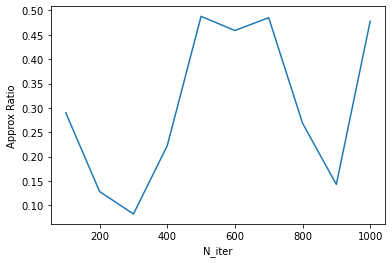

In [55]:
plt.plot(range(100,1001,100), np.array(final_states)/(-3))
plt.xlabel('N_iter')
plt.ylabel('Approx Ratio')

Optimal f1: -1.4149999999999996


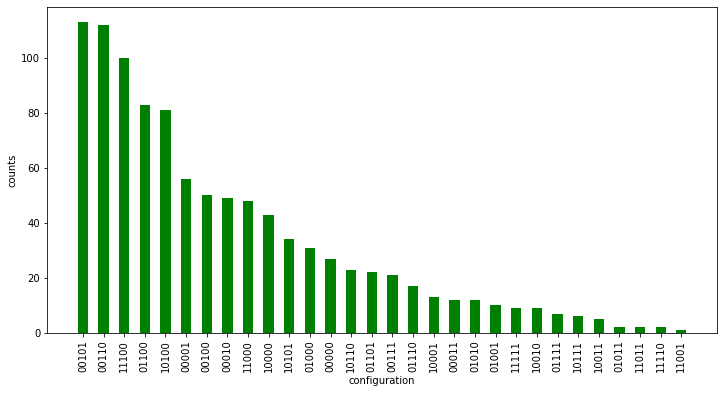

In [35]:
optimal_points = sample_points[-1]
optimal_f1, counts = QAOA(*optimal_points,shots=1000, basis="S")
print(f"Optimal f1: {optimal_f1}")
plot_distribution(counts)

In [37]:
np.savetxt('../data/raw/Bayes_search.dat', sample_points[:45])

100%|████████████████████████████████████████████████████████████████████████████| 40000/40000 [54:28<00:00, 12.24it/s]


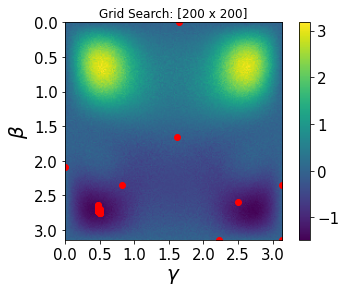

In [128]:
points = grid_search(200, shots=1000)
sample_points = np.array(sample_points)
plt.scatter(sample_points[:,0], sample_points[:,1], c = 'r')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()